In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, TimeDistributed, RepeatVector
from keras.regularizers import l2
#from keras.preprocessing import sequence

Using TensorFlow backend.
/home/lab606a/.virtualenvs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lab606a/.virtualenvs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lab606a/.virtualenvs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lab606a/.virtualenvs

In [2]:
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
# set GPU memory
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
dataset = pd.read_csv('./datasets/top_speed5_20200304.csv', header=None)
dataset = dataset.fillna(0)
dataset = np.array(dataset)
dataset.shape

(500, 72)

In [5]:
maxlen_train = dataset.shape[1]+12
print(maxlen_train)
dataset = sequence.pad_sequences(dataset, maxlen=maxlen_train, padding='post', dtype='float32')
dataset[0,:]

84


array([ 73.1795 , 300.655  ,  44.9941 ,  73.8959 , 281.147  ,  48.2543 ,
        73.5858 , 264.331  ,  50.8481 ,  73.9794 , 245.616  ,  51.6464 ,
        73.9052 , 229.073  ,  54.2783 ,  74.1134 , 228.405  ,  51.4868 ,
        74.002  , 211.73   ,  48.2324 ,  74.0943 , 194.375  ,  45.1484 ,
        73.9699 , 178.302  ,  40.6817 ,  73.8376 , 162.547  ,  34.7455 ,
        73.8587 , 142.089  ,  29.4841 ,  73.8788 , 125.952  ,  22.3073 ,
        73.8821 , 111.421  ,  13.3201 ,  73.7029 ,  97.5873 ,   3.73859,
        73.9222 ,  81.2214 ,  11.3436 ,  73.96   ,  65.6757 ,  18.3604 ,
        73.9765 ,  50.5348 ,  24.2557 ,  74.0932 ,  35.1753 ,  28.9134 ,
        74.1702 ,  20.1247 ,  32.1303 ,  74.325  ,   5.55638,  34.2497 ,
        74.4243 ,  -9.04841,  35.1984 ,  74.4748 , -23.3046 ,  34.8265 ,
        74.5713 , -37.0783 ,  33.4276 ,  74.5174 , -50.9649 ,  30.9661 ,
         0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
         0.     ,   0.     ,   0.     ,   0.     , 

In [6]:
n_step = 5
#depth = (dataset.shape[1]+1-((2*3*n_step)/3))*dataset.shape[0]
depth_train = (int(dataset.shape[1]/3)+1-n_step-n_step)*dataset.shape[0] # (all_balls + 1 - input_balls - output_balls)*n_rows
depth_train

9500

In [7]:
#X = np.zeros([int(depth), n_step, 3])
#Y = np.zeros([int(depth), n_step, 3])
#X.shape

In [8]:
def split(data, depth):
    dataset = data
    depth = depth
    X = np.zeros([int(depth), n_step, 3])
    Y = np.zeros([int(depth), n_step, 3])
    c = 0
    d = 0
    
    for i in range(int(depth)):
        for j in range(n_step):
            if d < dataset.shape[0]:
                X[i,j,:] = dataset[d, c:c+3]
                Y[i,j,:] = dataset[d, (c+3*n_step):(c+3*n_step+3)]
                
                if ((c+3*n_step+3) != (dataset.shape[1])):
                    c +=3
                else:
                    c = 0
                    d += 1
        if (c-3) > 0:
            c = (c - 3*n_step + 3)
        else:
            c = c
            
    return X, Y

In [9]:
x_train, y_train = split(data=dataset, depth=depth_train)

In [10]:
#x_train = x_train.astype('int')
x_train

array([[[ 73.17949677, 300.65499878,  44.99409866],
        [ 73.89589691, 281.14700317,  48.25429916],
        [ 73.58580017, 264.33099365,  50.84809875],
        [ 73.97940063, 245.61599731,  51.64640045],
        [ 73.90519714, 229.07299805,  54.27830124]],

       [[ 73.89589691, 281.14700317,  48.25429916],
        [ 73.58580017, 264.33099365,  50.84809875],
        [ 73.97940063, 245.61599731,  51.64640045],
        [ 73.90519714, 229.07299805,  54.27830124],
        [ 74.11340332, 228.40499878,  51.48680115]],

       [[ 73.58580017, 264.33099365,  50.84809875],
        [ 73.97940063, 245.61599731,  51.64640045],
        [ 73.90519714, 229.07299805,  54.27830124],
        [ 74.11340332, 228.40499878,  51.48680115],
        [ 74.0019989 , 211.72999573,  48.23239899]],

       ...,

       [[ 84.09320068,   8.44544029,  32.17539978],
        [ 84.71690369,  -6.88921022,  34.24319839],
        [ 85.30690002, -22.07189941,  35.35329819],
        [ 85.81590271, -37.28020096,  35.2971

In [11]:
#y_train = y_train.astype('int')
y_train

array([[[ 74.11340332, 228.40499878,  51.48680115],
        [ 74.0019989 , 211.72999573,  48.23239899],
        [ 74.09429932, 194.375     ,  45.14839935],
        [ 73.96990204, 178.30200195,  40.68170166],
        [ 73.83760071, 162.54699707,  34.74549866]],

       [[ 74.0019989 , 211.72999573,  48.23239899],
        [ 74.09429932, 194.375     ,  45.14839935],
        [ 73.96990204, 178.30200195,  40.68170166],
        [ 73.83760071, 162.54699707,  34.74549866],
        [ 73.85870361, 142.08900452,  29.48410034]],

       [[ 74.09429932, 194.375     ,  45.14839935],
        [ 73.96990204, 178.30200195,  40.68170166],
        [ 73.83760071, 162.54699707,  34.74549866],
        [ 73.85870361, 142.08900452,  29.48410034],
        [ 73.87879944, 125.95200348,  22.30730057]],

       ...,

       [[  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.    

In [12]:

model = Sequential()
model.add(LSTM(256, activation='linear', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(RepeatVector(x_train.shape[1]))
model.add(LSTM(256, activation='linear', return_sequences=True))
model.add(TimeDistributed(Dense(3)))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
model.summary()

#mean_absolute_error
#mean_absolute_percentage_error


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               266240    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 3)              771       
Total params: 792,323
Trainable params: 792,323
Non-trainable params: 0
_________________________________________________________________


In [13]:
'''
model = Sequential()
model.add(LSTM(256, activation='linear', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(128, activation='linear', return_sequences=True))
model.add(LSTM(64, activation='linear', return_sequences=True))
model.add(LSTM(32, activation='linear'))
model.add(RepeatVector(x_train.shape[1]))
model.add(LSTM(32, activation='linear', return_sequences=True))
model.add(LSTM(64, activation='linear', return_sequences=True))
model.add(LSTM(128, activation='linear', return_sequences=True))
model.add(LSTM(256, activation='linear', return_sequences=True))
model.add(TimeDistributed(Dense(3)))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
model.summary()
'''

"\nmodel = Sequential()\nmodel.add(LSTM(256, activation='linear', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))\nmodel.add(LSTM(128, activation='linear', return_sequences=True))\nmodel.add(LSTM(64, activation='linear', return_sequences=True))\nmodel.add(LSTM(32, activation='linear'))\nmodel.add(RepeatVector(x_train.shape[1]))\nmodel.add(LSTM(32, activation='linear', return_sequences=True))\nmodel.add(LSTM(64, activation='linear', return_sequences=True))\nmodel.add(LSTM(128, activation='linear', return_sequences=True))\nmodel.add(LSTM(256, activation='linear', return_sequences=True))\nmodel.add(TimeDistributed(Dense(3)))\n\nmodel.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])\nmodel.summary()\n"

In [14]:
history = model.fit(x_train, y_train, batch_size=500, epochs=10)
#history = model.fit(X, Y, batch_size=500, epochs=300, shuffle=True)

Epoch 1/10
9500/9500 [==============================] - 1s 105us/step - loss: 17.0104 - acc: 0.7834
Epoch 2/10
9500/9500 [==============================] - 0s 31us/step - loss: 4.4443 - acc: 0.8676
Epoch 3/10
9500/9500 [==============================] - 0s 35us/step - loss: 3.1699 - acc: 0.8759
Epoch 4/10
9500/9500 [==============================] - 0s 35us/step - loss: 3.0480 - acc: 0.8615
Epoch 5/10
9500/9500 [==============================] - 0s 31us/step - loss: 3.0016 - acc: 0.8721
Epoch 6/10
9500/9500 [==============================] - 0s 31us/step - loss: 2.8745 - acc: 0.8684
Epoch 7/10
9500/9500 [==============================] - 0s 32us/step - loss: 2.5214 - acc: 0.8680
Epoch 8/10
9500/9500 [==============================] - 0s 33us/step - loss: 2.6712 - acc: 0.8592
Epoch 9/10
9500/9500 [==============================] - 0s 29us/step - loss: 2.4363 - acc: 0.8751
Epoch 10/10
9500/9500 [==============================] - 0s 31us/step - loss: 2.2628 - acc: 0.8674


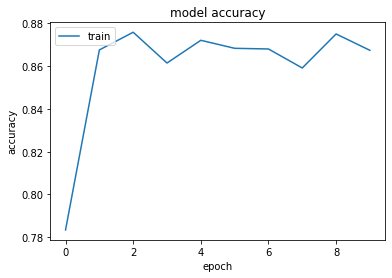

In [15]:
# summarize history for accuracy
plt.plot(history.history['acc'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

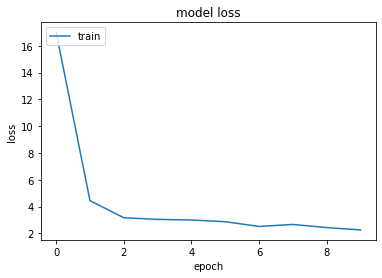

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
np.set_printoptions(suppress=True)

In [18]:
x_test = x_train[3,:,:]
x_test = x_test.reshape(1,n_step,3)
x_test

array([[[ 73.97940063, 245.61599731,  51.64640045],
        [ 73.90519714, 229.07299805,  54.27830124],
        [ 74.11340332, 228.40499878,  51.48680115],
        [ 74.0019989 , 211.72999573,  48.23239899],
        [ 74.09429932, 194.375     ,  45.14839935]]])

In [19]:
yhat = y_train[3,:,:]
yhat = yhat.reshape(1,n_step,3)
yhat

array([[[ 73.96990204, 178.30200195,  40.68170166],
        [ 73.83760071, 162.54699707,  34.74549866],
        [ 73.85870361, 142.08900452,  29.48410034],
        [ 73.87879944, 125.95200348,  22.30730057],
        [ 73.88210297, 111.42099762,  13.32009983]]])

In [20]:
pred = model.predict(x_test)
pred

array([[[ 72.7222  , 168.46533 ,  45.226   ],
        [ 71.91973 , 150.08055 ,  38.064316],
        [ 72.65187 , 133.66127 ,  32.921772],
        [ 73.464195, 118.18287 ,  27.092337],
        [ 73.28022 , 103.59999 ,  21.512215]]], dtype=float32)

In [21]:
error = yhat-pred
error

array([[[ 1.24770355,  9.83666992, -4.54430008],
        [ 1.91786957, 12.46644592, -3.31881714],
        [ 1.20683289,  8.42773438, -3.43767166],
        [ 0.41460419,  7.76913452, -4.78503609],
        [ 0.60188293,  7.82100677, -8.19211483]]])

In [22]:
dataset_test = pd.read_csv('./test/top_speed5_20200304_test.csv', header=None)
dataset_test = dataset_test.fillna(0)
dataset_test = np.array(dataset_test)
dataset_test.shape

(250, 78)

In [23]:
maxlen_test = dataset_test.shape[1]+12
dataset_test = sequence.pad_sequences(dataset_test, maxlen=maxlen_test, padding='post', dtype='float32')
dataset_test.shape

(250, 90)

In [24]:
depth_test = (int(dataset_test.shape[1]/3)+1-n_step-n_step)*dataset_test.shape[0] # (all_balls + 1 - input_balls - output_balls)*n_rows
depth_test

5250

In [25]:
x_test, y_test = split(data=dataset_test, depth=depth_test)

In [26]:
type(x_test)

numpy.ndarray

In [27]:
pred = model.predict(x_test)
pred

array([[[ 74.65938   , 203.66528   ,  52.181442  ],
        [ 74.00026   , 184.52435   ,  49.906616  ],
        [ 74.50339   , 167.06819   ,  47.189114  ],
        [ 74.8661    , 149.2971    ,  42.369064  ],
        [ 74.554695  , 132.90327   ,  36.477303  ]],

       [[ 74.609764  , 188.33516   ,  49.29311   ],
        [ 73.792404  , 169.9041    ,  45.830666  ],
        [ 74.741905  , 152.84814   ,  41.891632  ],
        [ 74.9238    , 135.69621   ,  36.43281   ],
        [ 75.801834  , 119.77616   ,  30.60807   ]],

       [[ 74.93289   , 171.691     ,  44.691303  ],
        [ 73.92414   , 153.89944   ,  38.81459   ],
        [ 74.68526   , 136.39026   ,  32.72299   ],
        [ 74.7718    , 120.06327   ,  25.710522  ],
        [ 74.51658   , 103.61649   ,  19.330221  ]],

       ...,

       [[  0.04571119,   0.01263228,   0.01778448],
        [  0.08435086,   0.02580857,   0.01282858],
        [  0.10156206,   0.02758793,   0.01673862],
        [  0.1070274 ,   0.01979916,   0.0217

In [28]:
y_test

array([[[ 76.82530212, 211.9750061 ,  50.10810089],
        [ 77.26399994, 197.48399353,  46.81729889],
        [ 77.66020203, 183.07400513,  42.67549896],
        [ 78.19850159, 168.02900696,  37.35160065],
        [ 78.47910309, 152.41099548,  31.42370033]],

       [[ 77.26399994, 197.48399353,  46.81729889],
        [ 77.66020203, 183.07400513,  42.67549896],
        [ 78.19850159, 168.02900696,  37.35160065],
        [ 78.47910309, 152.41099548,  31.42370033],
        [ 78.75060272, 138.49200439,  24.00399971]],

       [[ 77.66020203, 183.07400513,  42.67549896],
        [ 78.19850159, 168.02900696,  37.35160065],
        [ 78.47910309, 152.41099548,  31.42370033],
        [ 78.75060272, 138.49200439,  24.00399971],
        [ 78.83570099, 125.92299652,  15.3434    ]],

       ...,

       [[  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.    

In [29]:
error = y_test-pred
error

array([[[ 2.16592407,  8.3097229 , -2.07334137],
        [ 3.26374054, 12.9596405 , -3.08931732],
        [ 3.15681458, 16.0058136 , -4.51361465],
        [ 3.33240509, 18.73190308, -5.01746368],
        [ 3.92440796, 19.50772095, -5.05360222]],

       [[ 2.65423584,  9.14883423, -2.475811  ],
        [ 3.86779785, 13.16990662, -3.15516663],
        [ 3.45659637, 15.18086243, -4.54003143],
        [ 3.55530548, 16.71478271, -5.0091114 ],
        [ 2.94876862, 18.7158432 , -6.60407066]],

       [[ 2.72731018, 11.38301086, -2.01580429],
        [ 4.27436066, 14.12956238, -1.46298981],
        [ 3.79384613, 16.02073669, -1.2992878 ],
        [ 3.97880554, 18.42873383, -1.70652199],
        [ 4.31912231, 22.3065033 , -3.98682117]],

       ...,

       [[-0.04571119, -0.01263228, -0.01778448],
        [-0.08435086, -0.02580857, -0.01282858],
        [-0.10156206, -0.02758793, -0.01673862],
        [-0.1070274 , -0.01979916, -0.02173674],
        [-0.1059177 , -0.00412678, -0.02504053]],


In [30]:
error = error.reshape(error.shape[0]*error.shape[1], error.shape[2])
error.shape

(26250, 3)

In [31]:
y_test = y_test.reshape(y_test.shape[0]*y_test.shape[1], y_test.shape[2])
pred = pred.reshape(pred.shape[0]*pred.shape[1], pred.shape[2])
#pred.shape
tmp = np.hstack((y_test, pred))
tmp = np.hstack((tmp, error))

In [32]:
df = pd.DataFrame(tmp)
df
df.to_csv('./prediction_top5.csv',index=0 ,header=0)